here processed the film height fields with a fixed time interval. according Fourier frequencies was obtained wave characteristics

In [25]:
def init_matplotlib(name, font_path=None, fig_size_mm=(140, 70), dpi=150, 
                   font_size=12, output_format='jpg'):
    import matplotlib.font_manager as font_manager
    """Initialization params matplotlib with customizible parameters
    Args:
        name: matplotlib module (plt)
        font_path: the path to the font file
        fig_size_mm: the size of the figure in mm (width, height)
        dpi: resolution
        font_size: базовый размер шрифта
        output_format: формат сохранения
    """
    #reset to default settings
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    #font settings with error handling
    if font_path is None:
        font_path = 'c:\\windows\\fonts\\times.ttf'
    try:
        prop = font_manager.FontProperties(fname=font_path)
        name.rcParams['font.family'] = prop.get_name()
    except (OSError, RuntimeError) as e:
        print(f"Warning: The {font_path} font could not be loaded. The default font is used. Error: {e}")
        name.rcParams['font.family'] = 'serif'
    #converting mm to inches
    fig_size_inch = (fig_size_mm[0] / 25.4, fig_size_mm[1] / 25.4)
    #grouping parameters for batch installation
    params = {
        #dimension and resolution
        "figure.figsize": fig_size_inch,
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "savefig.format": output_format,
        #fonts
        "font.size": font_size,
        "axes.titlesize": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        #lines and msrkers
        "lines.linewidth": 0.5,
        "lines.markersize": 3.0,
        "lines.markeredgewidth": 1.0,
        "markers.fillstyle": 'none',
        #legend
        "legend.numpoints": 1,
        "legend.columnspacing": 1.5,
        "legend.handlelength": 2.0,
        #axes
        "axes.formatter.limits": (-7, 7),
        "axes.formatter.use_locale": True
    }
    name.rcParams.update(params)

#an alternative version with context return
def matplotlib_context(**kwargs):
    """
    Сontext manager for temporary application of settings
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from contextlib import contextmanager
    @contextmanager
    def context():
        original_params = mpl.rcParams.copy()
        try:
            init_matplotlib(plt, **kwargs)
            yield plt
        finally:
            mpl.rcParams.update(original_params)
    
    return context()

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import correlate

In [27]:
init_matplotlib(plt)

In [28]:
filepath = r'D:\ANES\ANES\anes20xe\stud-cases\nir1\v_fields\v2_mesh1\VOFFilmFlow_750_30\data\s2d_film_time_statistic.dat'
with open(filepath, 'r') as f:
    first_line = f.readline().strip() #1st strip
    #for structured mesh read width CV dx
    dxmesh = float(first_line)

In [29]:
data = pd.read_csv(filepath, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax*dxmesh
print(f"dxmesh = {dxmesh:.4g}")
print(f"NMax = {nmax:.4g}")
print(f"LMax = {lmax:.4g}")

dxmesh = 0.000153
NMax = 750
LMax = 0.1148


In [30]:
def N2X(n,dx):
    return n*dx
#choose points
n1 = 700
xp1 = N2X(n1,dxmesh)
n2 = 730
xp2 = N2X(n2,dxmesh)
print(f"delta21 = {xp2-xp1:.4g}")
name1 = "N" + str(n1)
name2 = "N" + str(n2)
tval = np.array(data["Time"])
delta1 = np.array(data[name1])
delta2 = np.array(data[name2])

delta21 = 0.004591


In [31]:
xp2 

0.11171189999999999

In [32]:
xp1

0.107121

In [33]:
patch2fileout = './/v2_figout_mesh1//timesignal_'
init_matplotlib(plt)

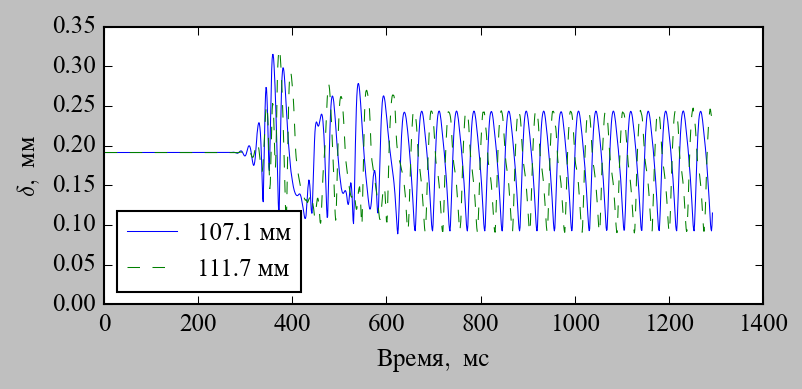

In [34]:
nameX = r'$\mathrm{Время,\ мс}$'
nameY = r'$\delta \mathrm{,\ мм}$'
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax1 = ax
ax1.plot(tval*1.0e3,delta1*1.0e3,'-b',label = f"{xp1*1000:.1f} мм")
ax1.plot(tval*1.0e3,delta2*1.0e3,'--g',label = f"{xp2*1000:.1f} мм")
ax1.set_xlim(xmin = 0.0)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
ax1.legend(loc='lower left')
#ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.savefig(patch2fileout, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [35]:
def freq_plot(sig, max_freq, fs):
    """
    Computes the amplitude spectrum of a signal using FFT
    Args:
        sig: input signal (1D array)
        max_freq: maximum frequency to display (Hz)
        fs: sampling frequency (Hz)
    
    Returns:
        f: frequency array [0, max_freq] (Hz)
        X: normalized amplitude spectrum
    """
    #сheck Nyquist criterion
    if max_freq > fs/2:
        raise ValueError(f'Max freq ({max_freq} Hz) must be <= Nyquist frequency ({fs/2} Hz)')
    N = len(sig)
    #сompute FFT and get amplitude spectrum
    X = np.abs(np.fft.fft(sig))
    #сreate frequency axis (two-sided spectrum)
    f = np.fft.fftfreq(N, 1/fs)
    #take only positive frequencies (one-sided spectrum)
    positive_freq = f >= 0
    f = f[positive_freq]
    X = X[positive_freq]
    #truncate to max_freq
    mask = f <= max_freq
    f = f[mask]
    X = X[mask]
    #normalization (multiply by 2 for all components except DC)
    X_norm = X / N * 2
    X_norm[0] = X_norm[0] / 2  #dc component should not be multiplied by 2
    return f, X_norm

In [36]:
def dominant_wavelengths(thickness, dx, top_n=1, max_lambda=None):
    """
    Finds dominant wavelengths in thickness profile using spectral analysis
    Args:
        thickness: thickness profile data (1D array)
        dx: spatial sampling interval (e.g., in meters)
        top_n: number of top dominant wavelengths to return
        max_lambda: maximum wavelength to consider (optional filter)
    Returns:
        dominant_lambdas: top N dominant wavelengths
        dominant_amps: corresponding amplitudes for dominant wavelengths
        lambdas: all wavelengths in the spectrum
        X: all amplitude values in the spectrum
    """
    #calculate spatial sampling frequency (1/dx)
    fs = 1.0 / dx
    #compute amplitude spectrum using FFT
    f, X = freq_plot(thickness, max_freq=fs/2, fs=fs)
    #convert to numpy arrays for safe indexing
    f = np.asarray(f)
    X = np.asarray(X)
    #remove zero frequency (DC component) and negative frequencies
    nonzero = f > 0
    f = f[nonzero]
    X = X[nonzero]
    #convert frequencies to wavelengths
    lambdas = 1.0 / f
    #filter out wavelengths longer than max_lambda if specified
    if max_lambda is not None:
        mask = lambdas <= max_lambda
        lambdas = lambdas[mask]
        X = X[mask]
    #sort by amplitude in descending order and get top N indices
    idx_sorted = np.argsort(X)[::-1]
    top_idx = idx_sorted[:top_n]
    #extract dominant wavelengths and their amplitudes
    dominant_lambdas = lambdas[top_idx]
    dominant_freq = f[top_idx][0]
    dominant_amps = X[top_idx]
    return dominant_lambdas, dominant_amps, dominant_freq, lambdas, X

In [37]:
patch2fileout = './/v2_figout_mesh1//freq_'
init_matplotlib(plt)
tshift = 0.3

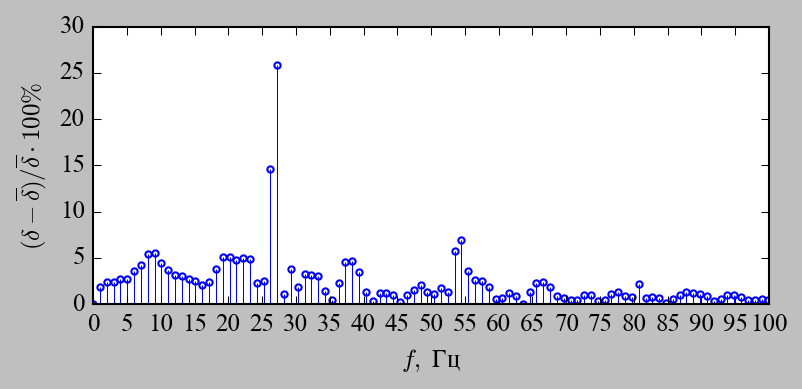

In [38]:
fig, ax = plt.subplots(nrows=1,ncols = 1)
nameX = r'$f \mathrm{,\ Гц}$'
nameY = r'$(\delta - \overline{\delta})/\overline{\delta} \cdot 100\%$'
fs = 1000
max_freq = 100
xmin, xmax, dx = 0.0, max_freq, 5.0
ymin, ymax, dy = 0.0, 25.0, 5.0
ax1 = ax
x1, y1 = tval[tval>=tshift], delta1[tval>=tshift]
X,Y = freq_plot((y1-np.average(y1))/np.average(y1)*100, max_freq, fs)
ax1.stem(X, Y)
ax1.set_xlim(xmin = xmin, xmax=xmax)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.tight_layout()
plt.savefig(patch2fileout)
plt.show()

In [39]:
i_maxFourier = np.argmax(Y)
f_maxFourier = X[i_maxFourier]
print(f'Maximum frequency from Fourier analysis {f_maxFourier}')
n_top = 5
top_indices = np.argsort(Y)[::-1]
top_frequencies = X[top_indices]
target_freqs = [53, 81]
for target in target_freqs:
    idx = np.argmin(np.abs(X - target))
    freq = X[idx]
    amp = Y[idx]
    print(f'Frequency near {target} Hz: {freq:.2f}')

Maximum frequency from Fourier analysis 27.2452068617558
Frequency near 53 Hz: 53.48
Frequency near 81 Hz: 80.73


In [40]:
top_indices

array([27, 26, 54, 53,  9,  8, 19, 20, 22, 23, 21, 38, 37, 10,  7, 29, 18,
       11, 55,  6, 39, 31, 32, 12, 13, 33,  4, 14,  5, 56, 15, 57, 25,  2,
       17,  3, 66, 36, 24, 65, 80, 48, 16, 67,  1, 30, 58, 51, 47, 34, 64,
       40, 49, 52, 77, 87, 42, 43, 88, 61, 76, 28, 50, 89, 94, 72, 73, 44,
       86, 93, 46, 68, 62, 90, 78, 82, 79, 95, 81, 60, 69, 83, 59, 98, 92,
       85, 75, 97, 70, 99, 96, 71, 35, 74, 91, 41, 45, 84, 63,  0])

In [41]:
timelook = 1.0
#choose minimum delta time
idx = (data["Time"] - timelook).abs().idxmin()
#array of delta x between points
deltaxdistr = np.array(data.loc[idx])[1:]
#linespace
xval = np.linspace(dxmesh/2, dxmesh/2 + (nmax-1)*dxmesh, nmax)
lambdadominant = dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[0][0]

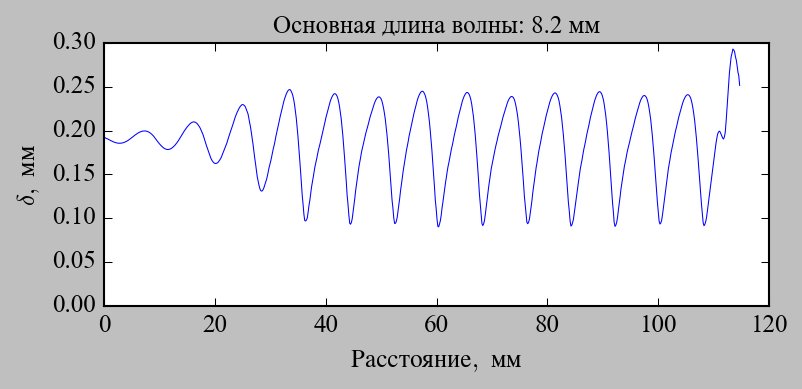

In [42]:
patch2fileout = './/v2_figout_mesh1//xsignal_'
init_matplotlib(plt)
fig, ax = plt.subplots(nrows=1,ncols = 1)
nameX = r'$\mathrm{Расстояние,\ мм}$'
nameY = r'$\delta,\ \mathrm{мм}$'
ax1 = ax
ax1.plot(xval*1.0e3,deltaxdistr*1.0e3,'-b',label = "-1")
ax1.set_xlim(xmin = 0.0)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
ax1.set_title(f"Основная длина волны: {lambdadominant*1.0e3:.3g} мм")
#ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.tight_layout()
plt.savefig(patch2fileout)
plt.show()

In [43]:
#filtering
y2 = delta2[tval>=tshift]
#correlation
corr = correlate(y1, y2, mode='full')
#lags
lags = np.arange(-len(y1)+1, len(y2))
lag_max = lags[np.argmax(corr)]
#shift time
time_shift = lag_max / fs
print(f"Сдвиг между сигналами: {lag_max} отсчётов, или {time_shift:.6f} s")
uw = abs(xp2-xp1)*1.0e3/abs(time_shift)
print(f"Фазовая скорость: {uw:.3g} mm/s")

Сдвиг между сигналами: -19 отсчётов, или -0.019000 s
Фазовая скорость: 242 mm/s


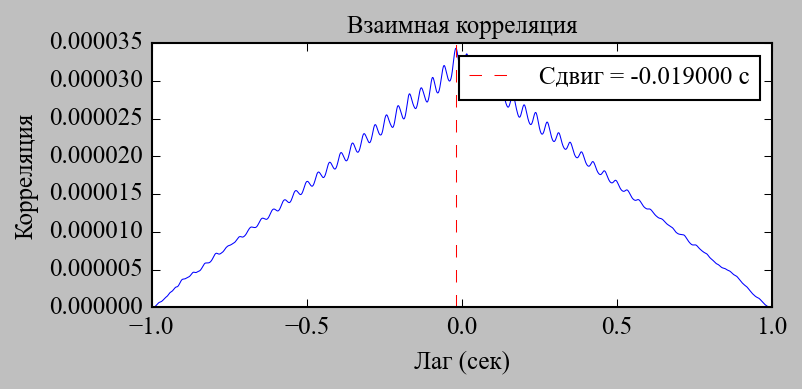

In [44]:
patch2fileout = './/v2_figout_mesh1//corr_'
fig, ax = plt.subplots(nrows=1, ncols=1)
ax1 = ax
ax1.plot(lags/fs, corr)
ax1.axvline(time_shift, color='r', linestyle='--', label=f"Сдвиг = {time_shift:.6f} c")
ax1.set_xlabel("Лаг (сек)")
ax1.set_ylabel("Корреляция")
ax1.legend()
ax1.set_title("Взаимная корреляция")
plt.tight_layout()
plt.savefig(patch2fileout)
plt.show()

have been obtained frequency and amplitude of the waves

In [45]:
print('Amplitude ',dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[1][0])

Amplitude  4.894376410820141e-05


In [46]:
print('Frequence ',dominant_wavelengths(deltaxdistr, dxmesh, top_n=1, max_lambda=None)[2])

Frequence  121.98043956522689
